![Colegio Bourbaki](./Images/Bourbaki.png)

## Machine Learning & AI

### Introducción a modelos autorregresivos

### Contexto

Vamos a utilizar la base de datos de Hoteles de Chigago para clasificar las etiquetas.

### Librerías

In [ ]:
# Data Analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing
import spacy

# LSTM
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

# Utils
import os
import re
import sys
from collections import Counter
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

### Configuración

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # Sirve para debuggear errores en CUDA
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32" # Evita errores de memoria en CUDA asignando bloques mas chicos de memoria
torch.backends.cudnn.enabled = (
    True  # Habilita cuDNN para acelerar operaciones de redes neuronales en CUDA
)
torch.backends.cudnn.benchmark = False  # Deshabilita la busqueda automatica de la mejor configuracion de cuDNN para evitar variabilidad en tiempos de ejecucion
torch.backends.cuda.matmul.allow_tf32 = True # Autoriza el uso de TensorFloat-32 en multiplicaciones de matrices en CUDA para mejorar el rendimiento (mayor velocidad con posible perdida de precision)
torch.backends.cudnn.allow_tf32 = True # Autoriza el uso de TensorFloat-32 en convoluciones en CUDA para mejorar el rendimiento (mayor velocidad con posible perdida de precision)
torch.cuda.empty_cache() # Limpia la memoria cache de CUDA para liberar espacio no utilizado

In [6]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)
print(
    "__CUDA VERSION",
)
! nvidia-smi
print("__CUDNN VERSION:", torch.backends.cudnn.version())
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Active CUDA Device: GPU", torch.cuda.current_device())
print("Available devices ", torch.cuda.device_count())
print("Current cuda device ", torch.cuda.current_device())

__Python VERSION: 3.12.11 (main, Sep  5 2025, 19:35:43) [GCC 13.3.0]
__pyTorch VERSION: 2.8.0+cu128
__CUDA VERSION
Mon Nov  3 20:11:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   65C    P8              6W /   50W |     260MiB /   4096MiB |     21%      Default |
|                        

In [7]:
nlp = spacy.load(
    "en_core_web_sm", disable=["ner", "parser"]
)  # solo necesitamos tokenizer + tagger + lemmatizer

In [8]:
def preprocessing(text):
    """
    Preprocesa texto en inglés usando spaCy:
    - Minúsculas
    - Tokeniza
    - Quita puntuación, números y stopwords
    - Lematiza con POS
    """
    if not isinstance(text, str):
        return ""

    doc = nlp(text.lower())
    words = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 2
    ]
    return " ".join(words)

In [9]:
def confusion_matrix(y_real, y_pred):
    """ Muestra la matrix de confusión entre datos reales y predichos por un modelo"""
    data = {'Y_Real': y_real,
            'Y_Prediccion': y_pred
            }

    df = pd.DataFrame(data, columns=['Y_Real', 'Y_Prediccion'])
    confusion_matrix = pd.crosstab(df['Y_Real'], df['Y_Prediccion'], rownames=['Real'], colnames=['Predicted'])

    sns.heatmap(confusion_matrix, annot=True, fmt='g')
    plt.show()

In [10]:
def plot_ovr_roc(
    y_true,
    y_score,
    classes=None,
    title="One-vs-Rest ROC",
    add_micro=True,
    add_macro=True,
):
    """
    Plot OvR ROC curves for a multiclass classifier.

    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True class labels.

    y_score : array-like of shape (n_samples, n_classes)
        Per-class scores (e.g., predict_proba or decision_function).
        Must have one column per class in `classes` order.

    classes : list/array of shape (n_classes,), optional
        Class labels in the exact order that matches y_score's columns.
        If None, inferred from y_true (and must match y_score columns).

    add_micro : bool
        Plot micro-average ROC.

    add_macro : bool
        Plot macro-average ROC.
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    if classes is None:
        classes = np.unique(y_true)
    classes = np.asarray(classes)

    if y_score.ndim != 2 or y_score.shape[1] != len(classes):
        raise ValueError(
            "y_score must be (n_samples, n_classes) and match len(classes)."
        )

    # Binarize y
    y_true_bin = label_binarize(y_true, classes=classes)

    fpr, tpr, roc_auc = {}, {}, {}

    # Per-class ROC
    for i, cls in enumerate(classes):
        y_i = y_true_bin[:, i]
        # Need both positive and negative samples to compute ROC
        if y_i.sum() == 0 or y_i.sum() == y_i.shape[0]:
            # skip classes with only one label present
            continue
        fpr[cls], tpr[cls], _ = roc_curve(y_i, y_score[:, i])
        roc_auc[cls] = auc(fpr[cls], tpr[cls])

    # Micro-average
    if add_micro and len(roc_auc) > 0:
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    if add_macro and len(roc_auc) > 0:
        # Aggregate all fpr points
        class_keys = [k for k in roc_auc.keys() if k not in ("micro", "macro")]
        all_fpr = np.unique(np.concatenate([fpr[k] for k in class_keys]))
        mean_tpr = np.zeros_like(all_fpr)
        for k in class_keys:
            mean_tpr += np.interp(all_fpr, fpr[k], tpr[k])
        mean_tpr /= len(class_keys)
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot
    plt.figure(figsize=(8, 6))
    color_cycle = cycle([f"C{i}" for i in range(10)])

    # Per-class curves
    for cls, color in zip(
        [k for k in roc_auc.keys() if k not in ("micro", "macro")], color_cycle
    ):
        plt.plot(fpr[cls], tpr[cls], lw=2, label=f"{cls} (AUC={roc_auc[cls]:.2f})")

    # Micro / Macro
    if "micro" in roc_auc:
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            linestyle=":",
            lw=2,
            label=f"micro (AUC={roc_auc['micro']:.2f})",
        )
    if "macro" in roc_auc:
        plt.plot(
            fpr["macro"],
            tpr["macro"],
            linestyle="--",
            lw=2,
            label=f"macro (AUC={roc_auc['macro']:.2f})",
        )

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right", fontsize="small")
    plt.tight_layout()
    plt.show()

### Carga de Datos

In [11]:
data = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/LogisticRegression_SpamOpinion/master/Datos/deceptive-opinion.csv')

In [12]:
data

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   deceptive  1600 non-null   object
 1   hotel      1600 non-null   object
 2   polarity   1600 non-null   object
 3   source     1600 non-null   object
 4   text       1600 non-null   object
dtypes: object(5)
memory usage: 62.6+ KB


In [14]:
display(data["polarity"].value_counts(), data["deceptive"].value_counts())

polarity
positive    800
negative    800
Name: count, dtype: int64

deceptive
truthful     800
deceptive    800
Name: count, dtype: int64

In [15]:
data['text'][0]

'We stayed for a one night getaway with family on a thursday. Triple AAA rate of 173 was a steal. 7th floor room complete with 44in plasma TV bose stereo, voss and evian water, and gorgeous bathroom(no tub but was fine for us) Concierge was very helpful. You cannot beat this location... Only flaw was breakfast was pricey and service was very very slow(2hours for four kids and four adults on a friday morning) even though there were only two other tables in the restaurant. Food was very good so it was worth the wait. I would return in a heartbeat. A gem in chicago... \n'

In [16]:
data["len_text"] = data["text"].str.split().str.len()

In [17]:
data

,deceptive,hotel,polarity,source,text,len_text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,105
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,45
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...,207
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...,127
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...,72
...,...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...,131
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...,121
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...,141
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...",86


In [18]:
data['len_text'].describe()

count    1600.000000
mean      148.775000
std        87.335984
min        25.000000
25%        88.000000
50%       128.000000
75%       182.250000
max       784.000000
Name: len_text, dtype: float64

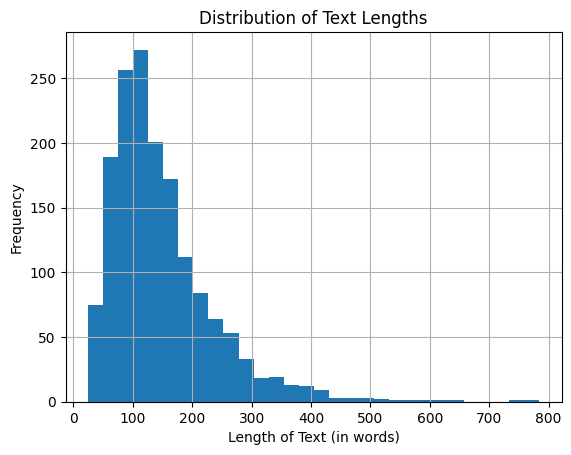

In [19]:
data['len_text'].hist(bins=30)
plt.xlabel('Length of Text (in words)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [20]:
data['text_process'] = data['text'].apply(preprocessing)  # Aplicamos la función de preprocesamiento

In [21]:
data["len_text_process"] = data["text_process"].str.split().str.len()

In [22]:
data

,deceptive,hotel,polarity,source,text,len_text,text_process,len_text_process
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,105,stay night getaway family thursday triple aaa ...,43
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,45,triple rate upgrade view room include breakfas...,27
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...,207,come little late finally catch review past mon...,90
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...,127,omni chicago deliver front spaciousness room h...,58
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...,72,ask high floor away elevator get room pleasant...,28
...,...,...,...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...,131,problem start book intercontinental chicago on...,57
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...,121,amalfi hotel beautiful website interior decora...,47
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...,141,intercontinental chicago magnificent mile outs...,55
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...",86,palmer house hilton look good picture outside ...,33


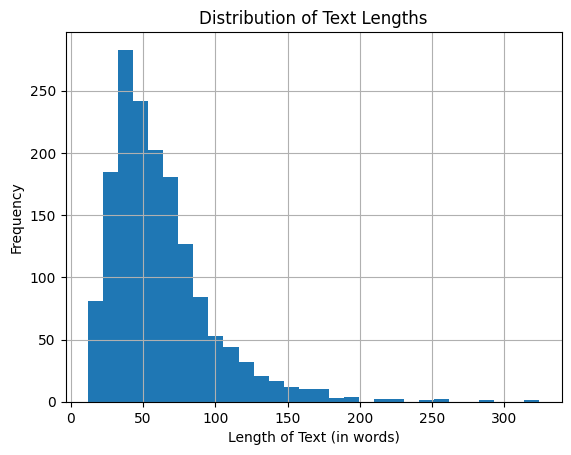

In [23]:
data["len_text_process"].hist(bins=30)
plt.xlabel("Length of Text (in words)")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

In [24]:
data['len_text_process'].describe()

count    1600.000000
mean       61.893125
std        35.066583
min        12.000000
25%        38.000000
50%        54.000000
75%        77.000000
max       324.000000
Name: len_text_process, dtype: float64

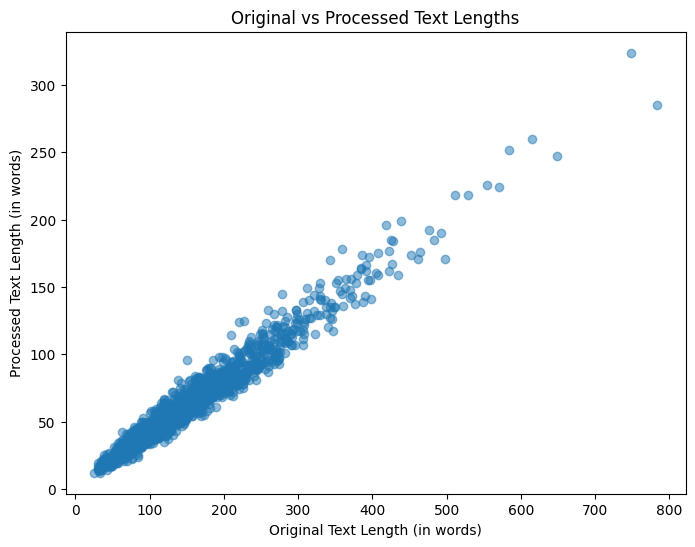

In [25]:
# Plot scattered plot between original and processed text lengths
plt.figure(figsize=(8, 6))
plt.scatter(data['len_text'], data['len_text_process'], alpha=0.5)
plt.xlabel('Original Text Length (in words)')
plt.ylabel('Processed Text Length (in words)')
plt.title('Original vs Processed Text Lengths')
plt.show()

In [26]:
# assuming df is your DataFrame
mapping = {
    ("truthful", "positive"): 0,
    ("truthful", "negative"): 1,
    ("deceptive", "positive"): 2,
    ("deceptive", "negative"): 3,
}

data["label"] = data.apply(lambda x: mapping[(x["deceptive"], x["polarity"])], axis=1)

In [27]:
data

,deceptive,hotel,polarity,source,text,len_text,text_process,len_text_process,label
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...,105,stay night getaway family thursday triple aaa ...,43,0
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...,45,triple rate upgrade view room include breakfas...,27,0
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...,207,come little late finally catch review past mon...,90,0
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...,127,omni chicago deliver front spaciousness room h...,58,0
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...,72,ask high floor away elevator get room pleasant...,28,0
...,...,...,...,...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...,131,problem start book intercontinental chicago on...,57,3
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...,121,amalfi hotel beautiful website interior decora...,47,3
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...,141,intercontinental chicago magnificent mile outs...,55,3
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i...",86,palmer house hilton look good picture outside ...,33,3


In [28]:
data['label'].value_counts()

label
0    400
2    400
1    400
3    400
Name: count, dtype: int64

### Modelo RNN/LSTM

**Redes Neuronales Recurrentes (RNN):**

Las RNN son un tipo de red neuronal artificial diseñadas para reconocer patrones en secuencias de datos como series temporales, lenguaje hablado, texto escrito o datos financieros. Para nuestro caso, una RNN podría usar datos históricos sobre la tasa de ocupación de los trenes para aprender a predecir futuras tasas de ocupación. Lo que hace especial a las RNN es su capacidad de memoria a corto plazo. Pueden recordar información previa en la secuencia y usarla para influir en la salida actual. Sin embargo, las RNN tradicionales luchan con dependencias a largo plazo debido a problemas como la desaparición o la explosión del gradiente.

![RNN](./Images/RNNIO.png)

Fuente: Chapter 6 - Python Deep Learning - Ivan Vasilev

**Long Short-Term Memory (LSTM):**

Las LSTM son una mejora de las RNN convencionales. Están específicamente diseñadas para evitar el problema de la dependencia a largo plazo, permitiendo que el modelo aprenda qué información es relevante para mantener o descartar a lo largo de grandes intervalos de tiempo. Esto se logra a través de estructuras llamadas celdas de memoria que tienen puertas para regular el flujo de información. Estas puertas pueden aprender cuáles datos son importantes y por lo tanto deben ser recordados y cuáles pueden ser olvidados. En el contexto de la tasa de ocupación de los trenes, una LSTM podría potencialmente capturar complejas relaciones temporales, como los patrones de afluencia de pasajeros en diferentes estaciones durante diferentes horarios y días, mejorando la precisión de las predicciones.

![RNN](./Images/LSTMarch.png)

![RNN](./Images/LSTMflow.png)

Fuente: Chapter 6 - Python Deep Learning - Ivan Vasilev

En resumen, las RNN y las LSTM son adecuadas para modelar problemas donde los datos vienen en secuencias y la información histórica es crucial para hacer predicciones. Para la predicción de la tasa de ocupación de los trenes, una LSTM probablemente superará a una RNN estándar, ya que puede manejar mejor las dependencias temporales a largo plazo que son comunes en los datos de tráfico de pasajeros.

Vamos a definir la arquitectura de la red recurrente:

In [29]:
def basic_tokenize(text):
    # keep words and apostrophes, split on non-letters
    tokens = re.findall(r"[a-zA-Z']+", text)
    return [t for t in tokens if t.strip("'")]

In [30]:
texts = data["text_process"].astype(str).tolist()
labels = data["label"].astype(int).tolist()

In [33]:
# split first to avoid vocab leakage from test (optional but nicer)
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels
)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.05, stratify=y_temp
)

In [35]:
# Print dataset sizes
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}") 
print(f"Test size: {len(X_test)}")

Train size: 1216
Validation size: 64
Test size: 320


In [37]:
# build vocab on train set
counter = Counter()
for t in X_train:
    counter.update(basic_tokenize(t))

MAX_VOCAB = 20000
min_freq = 2

# specials
PAD, UNK = "<pad>", "<unk>"

itos = [PAD, UNK]
for tok, freq in counter.most_common():
    if freq < min_freq:
        break
    if len(itos) >= MAX_VOCAB:
        break
    itos.append(tok)
stoi = {tok: i for i, tok in enumerate(itos)}


def numericalize(tokens):
    return [stoi.get(tok, stoi[UNK]) for tok in tokens]

In [38]:
counter

Counter({'room': 2621,
         'dingy': 11,
         'run': 55,
         'feel': 231,
         'like': 458,
         'stay': 1716,
         'cheap': 57,
         'motel': 25,
         'carpet': 62,
         'exceptionally': 8,
         'worn': 9,
         'wallpaper': 9,
         'peeling': 1,
         'bathroom': 286,
         'grout': 3,
         'place': 335,
         'redecorate': 2,
         'year': 117,
         'window': 79,
         'open': 93,
         'unusual': 5,
         'hig': 1,
         'rise': 4,
         'hotel': 2817,
         'air': 59,
         'fan': 19,
         'heat': 11,
         'temp': 6,
         'control': 14,
         'suppose': 46,
         'work': 203,
         'idea': 20,
         'say': 156,
         'radient': 1,
         'cooling': 1,
         'desk': 370,
         'ask': 223,
         'floor': 204,
         'cool': 49,
         'circulation': 1,
         'go': 329,
         'far': 63,
         'prop': 3,
         'door': 166,
         'suffocated'

In [39]:
itos, len(itos)

(['<pad>',
  '<unk>',
  'hotel',
  'room',
  'stay',
  'chicago',
  'service',
  'staff',
  'great',
  'night',
  'bed',
  'good',
  'check',
  'like',
  'time',
  'clean',
  'nice',
  'location',
  'desk',
  'get',
  'look',
  'day',
  'place',
  'go',
  'find',
  'experience',
  'bathroom',
  'restaurant',
  'view',
  'recommend',
  'come',
  'friendly',
  'comfortable',
  'price',
  'walk',
  'feel',
  'area',
  'business',
  'want',
  'ask',
  'book',
  'take',
  'lobby',
  'pay',
  'arrive',
  'tell',
  'small',
  'well',
  'call',
  'city',
  'floor',
  'need',
  'work',
  'food',
  'minute',
  'breakfast',
  'bar',
  'guest',
  'visit',
  'think',
  'bad',
  'definitely',
  'reservation',
  'give',
  'wait',
  'leave',
  'suite',
  'hour',
  'expect',
  'free',
  'trip',
  'weekend',
  'door',
  'beautiful',
  'helpful',
  'offer',
  'know',
  'thing',
  'right',
  'say',
  'way',
  'love',
  'hilton',
  'downtown',
  'water',
  'wonderful',
  'charge',
  'try',
  'enjoy',
  'cl

In [40]:
stoi

{'<pad>': 0,
 '<unk>': 1,
 'hotel': 2,
 'room': 3,
 'stay': 4,
 'chicago': 5,
 'service': 6,
 'staff': 7,
 'great': 8,
 'night': 9,
 'bed': 10,
 'good': 11,
 'check': 12,
 'like': 13,
 'time': 14,
 'clean': 15,
 'nice': 16,
 'location': 17,
 'desk': 18,
 'get': 19,
 'look': 20,
 'day': 21,
 'place': 22,
 'go': 23,
 'find': 24,
 'experience': 25,
 'bathroom': 26,
 'restaurant': 27,
 'view': 28,
 'recommend': 29,
 'come': 30,
 'friendly': 31,
 'comfortable': 32,
 'price': 33,
 'walk': 34,
 'feel': 35,
 'area': 36,
 'business': 37,
 'want': 38,
 'ask': 39,
 'book': 40,
 'take': 41,
 'lobby': 42,
 'pay': 43,
 'arrive': 44,
 'tell': 45,
 'small': 46,
 'well': 47,
 'call': 48,
 'city': 49,
 'floor': 50,
 'need': 51,
 'work': 52,
 'food': 53,
 'minute': 54,
 'breakfast': 55,
 'bar': 56,
 'guest': 57,
 'visit': 58,
 'think': 59,
 'bad': 60,
 'definitely': 61,
 'reservation': 62,
 'give': 63,
 'wait': 64,
 'leave': 65,
 'suite': 66,
 'hour': 67,
 'expect': 68,
 'free': 69,
 'trip': 70,
 'weeken

In [41]:
class ReviewsDS(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        toks = basic_tokenize(self.texts[idx])
        ids = torch.tensor(numericalize(toks), dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return ids, y

In [ ]:
train_ds = ReviewsDS(X_train, y_train)
val_ds = ReviewsDS(X_val, y_val)
test_ds = ReviewsDS(X_test, y_test)

In [44]:
# Hyperparameters
BATCH_SIZE = 32

In [45]:
def collate_fn(batch, max_len=128):
    seqs, ys = zip(*batch)
    # truncate
    seqs = [s[:max_len] for s in seqs]
    # pad to max in batch (or fixed max_len for speed-consistency)
    padded = pad_sequence(seqs, batch_first=True, padding_value=stoi[PAD])
    lengths = torch.tensor([min(len(s), max_len) for s in seqs], dtype=torch.long)
    return padded, lengths, torch.stack(ys)

La función collate_fn sirve para preparar los lotes (batches) de datos que se entregan al modelo en PyTorch

Cuando las secuencias (por ejemplo, frases tokenizadas) tienen longitudes variables, esta función:

* Trunca las secuencias demasiado largas.
* Rellena (pad) las secuencias cortas con un símbolo especial.
* Devuelve las longitudes reales (sin contar el relleno).
* Agrupa las etiquetas (y) en un solo tensor.

In [46]:
train_dl = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
val_dl = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)
test_dl = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)

In [47]:
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        hidden,
        num_layers,
        num_classes,
        p,
        pad_idx=0,
        bidirectional=True,
    ):
        super().__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(hidden * self.num_directions, num_classes)

    def forward(self, x, lengths):
        # x: (B, T)
        emb = self.emb(x)  # (B, T, E)
        # pack for efficiency
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        out, (hn, cn) = self.lstm(packed)
        if self.bidirectional:
            # concat forward + backward final hidden states
            h_forward = hn[-2, :, :]
            h_backward = hn[-1, :, :]
            h = torch.cat([h_forward, h_backward], dim=1)
        else:
            # single last hidden state
            h = hn[-1, :, :]

        h = self.dropout(h)
        return self.fc(h)  # (B, num_classes)

In [48]:
LR = 1e-3
EPOCHS = 20
EMB_DIM = 100
HIDDEN_DIM = 64
NUM_LAYERS = 1
CLASSES = len(np.unique(labels))
DO = 0.1
BID = False

In [49]:
model = LSTMClassifier(
    vocab_size=len(itos),
    emb_dim=EMB_DIM,
    hidden=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=CLASSES,
    p=DO,
    pad_idx=stoi[PAD],
    bidirectional=BID,
).to(device)

In [50]:
model

LSTMClassifier(
  (emb): Embedding(3351, 100, padding_idx=0)
  (lstm): LSTM(100, 64, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [51]:
class AvgMeter:
    def __init__(self):
        self.n = 0
        self.s = 0.0

    def update(self, v, k=1):
        self.s += v * k
        self.n += k

    @property
    def avg(self):
        return self.s / max(self.n, 1)


criterion = nn.CrossEntropyLoss() #BCEWithLogitsLoss(), #BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=LR*0.1, amsgrad=True)

In [52]:
best_acc = 0.0


def run_epoch(dl, train=True):
    model.train() if train else model.eval()
    meter = AvgMeter()
    y_true, y_pred = [], []
    for x, lengths, y in dl:
        x, lengths, y = x.to(device), lengths.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            logits = model(x, lengths)
            loss = criterion(logits, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        meter.update(loss.item(), k=len(y))
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.detach().cpu().tolist())
        y_pred.extend(preds.detach().cpu().tolist())
    acc = accuracy_score(y_true, y_pred)
    return meter.avg, acc, (y_true, y_pred)

In [53]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc, (y_true_train, y_pred_train) = run_epoch(train_dl, train=True)
    val_loss, val_acc, (y_true_val, y_pred_val) = run_epoch(val_dl, train=False)

    # save for plotting
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)
    
    print(
        f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | valid_loss={val_loss:.4f} val_acc={val_acc:.4f}"
    )
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(
            {"model_state": model.state_dict(), "stoi": stoi, "itos": itos},
            "best_lstm.pt",
        )

Epoch 01 | train_loss=1.3795 train_acc=0.2944 | valid_loss=1.3602 val_acc=0.3125
Epoch 02 | train_loss=1.3118 train_acc=0.4293 | valid_loss=1.3092 val_acc=0.4062
Epoch 03 | train_loss=1.1616 train_acc=0.5082 | valid_loss=1.2264 val_acc=0.4219
Epoch 04 | train_loss=1.0015 train_acc=0.6012 | valid_loss=1.0132 val_acc=0.5000
Epoch 05 | train_loss=0.8176 train_acc=0.6891 | valid_loss=0.9669 val_acc=0.5312
Epoch 06 | train_loss=0.6881 train_acc=0.7516 | valid_loss=0.9763 val_acc=0.4688
Epoch 07 | train_loss=0.5557 train_acc=0.7961 | valid_loss=0.9187 val_acc=0.5000
Epoch 08 | train_loss=0.4812 train_acc=0.8322 | valid_loss=1.0592 val_acc=0.4844
Epoch 09 | train_loss=0.4022 train_acc=0.8586 | valid_loss=1.1181 val_acc=0.4844
Epoch 10 | train_loss=0.3381 train_acc=0.8766 | valid_loss=1.0900 val_acc=0.5156
Epoch 11 | train_loss=0.2521 train_acc=0.9161 | valid_loss=1.1356 val_acc=0.5469
Epoch 12 | train_loss=0.1967 train_acc=0.9589 | valid_loss=1.3342 val_acc=0.5312
Epoch 13 | train_loss=0.1404

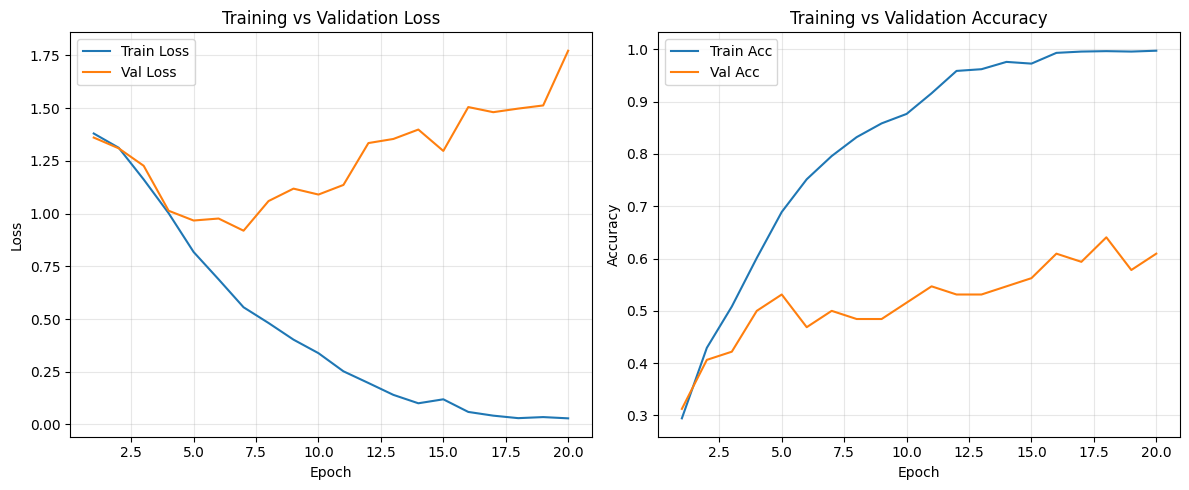

In [54]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

# --- Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Que esta sucediendo?**

In [55]:
_, _, (y_true_test, y_pred_test) = run_epoch(test_dl, train=False)

In [56]:
print("Best valid accuracy:", best_acc, '\n')

# Evaluate
print(
    "Classification Report:\n",
    classification_report(y_true_test, y_pred_test),
)

print("Train Accuracy:", accuracy_score(y_true_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_true_test, y_pred_test), '\n')

Best valid accuracy: 0.640625 

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70        80
           1       0.57      0.56      0.57        80
           2       0.75      0.80      0.78        80
           3       0.64      0.65      0.65        80

    accuracy                           0.67       320
   macro avg       0.67      0.67      0.67       320
weighted avg       0.67      0.67      0.67       320

Train Accuracy: 0.9975328947368421
Test Accuracy: 0.671875 



Confusion Matrix:


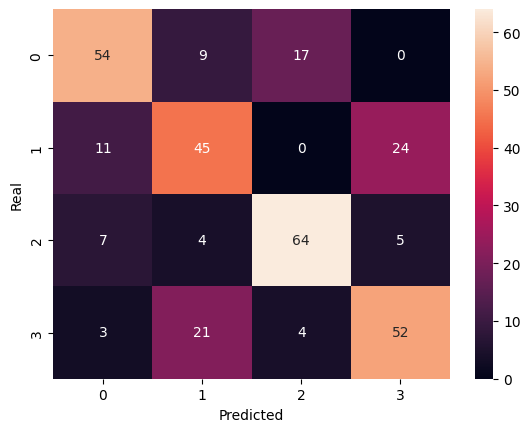

None


In [57]:
print("Confusion Matrix:")
print(confusion_matrix(y_true_test, y_pred_test))

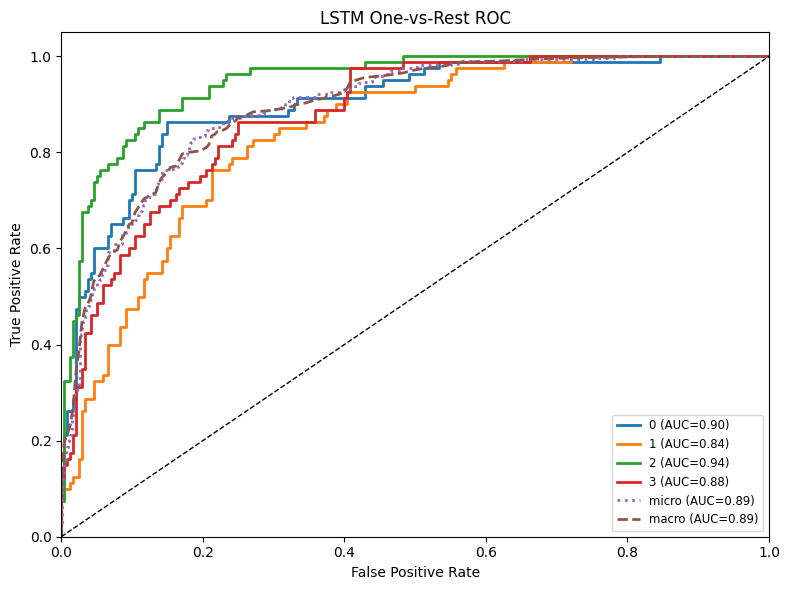

In [58]:
all_probs = []
all_true = []

with torch.no_grad():
    for x, lengths, y in test_dl:
        x, lengths = x.to(device), lengths.to(device)
        logits = model(x, lengths)  # (B, num_classes)
        probs = torch.softmax(logits, dim=1)  # convert logits -> probabilities
        all_probs.append(probs.cpu().numpy())
        all_true.append(y.cpu().numpy())

y_score = np.vstack(all_probs)  # shape: (n_samples, n_classes)
y_true = np.concatenate(all_true)  # shape: (n_samples,)

plot_ovr_roc(
    y_true=y_true, y_score=y_score, title="LSTM One-vs-Rest ROC"
)

### Ejercicios:


* Mejorar el modelo.

### Preguntas:

1) ¿Qué características de las RNN las hacen adecuadas para modelar secuencias de datos?

2) ¿Pueden explicar cómo las LSTM mejoran el desempeño de las RNN estándar y qué problemas específicos resuelven?

3) ¿Cómo se manejan las dependencias a largo plazo en los datos secuenciales utilizando LSTM?

4) ¿Cuáles son las diferencias clave entre una unidad LSTM y una neurona típica en una red neuronal?

5) ¿Por qué es importante el proceso de "olvido" en una LSTM y cómo se implementa este mecanismo?

6) ¿Cómo se determina la cantidad de capas LSTM y la cantidad de unidades en cada capa para un problema de predicción de secuencias?

8) ¿Qué técnicas utilizarían para evitar el sobreajuste en un modelo LSTM?

9) ¿De qué manera la longitud de la secuencia de entrada afecta el rendimiento del modelo LSTM y cómo podrían decidir la longitud adecuada para su problema?

10) ¿Pueden describir cómo se realiza la retropropagación a través del tiempo (BPTT) en las LSTMs?

11) ¿Qué métricas de desempeño considerarían más importantes para evaluar la precisión de las predicciones de su modelo y por qué?

### Referencias:

* LSTM for Time Series Prediction in PyTorch: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

* How to apply LSTM using PyTorch: https://cnvrg.io/pytorch-lstm/

![Lenguaje Matemático](./Images/Matematicas.png)

![Contacto](./Images/Contacto.png)